# Tugas Besar 2 Inteligensi Buatan

<b>Kelompok ChiMonke</b>
|No|        Nama          |    NIM    |
|--|----------------------|-----------|
|1.|Michael Jonathan Halim| 13521124  |
|2.|Chiquita Ahsanunnisa  | 13521129  |
|3.|Enrique Alifio Ditya  |	13521142  |
|4.|Rava Maulana		  | 13521149  |

## Import Libraries

In [1]:
import pandas as pd

## Constants

In [2]:
from matplotlib.colors import LinearSegmentedColormap

TARGET = "price_range"
RANDOM_STATE = 42

THEME = 'orangered'
CMAP_COLOUR = LinearSegmentedColormap.from_list(THEME, ['#FFECEC',THEME])

NUM_FEAT = ["battery_power", "clock_speed", "fc", "int_memory", "m_dep", "mobile_wt", "n_cores", "pc", "px_height", "px_width", "ram", "sc_h", "sc_w", "talk_time"]
CAT_FEAT = ["blue", "dual_sim", "four_g", "three_g", "touch_screen", "wifi"]

## Import Dataset

In [3]:
train_set = pd.read_csv("../data/data_train.csv")
train_set.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0


In [4]:
val_set = pd.read_csv("../data/data_validation.csv")
val_set.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
2,769,1,2.9,1,0,0,9,0.1,182,5,...,248,874,3946,5,2,7,0,0,0,3
3,775,0,1.0,0,3,0,46,0.7,159,2,...,862,1864,568,17,15,11,1,1,1,0
4,595,0,0.9,1,7,1,23,0.1,121,3,...,441,810,3752,10,2,18,1,1,0,3


# Why do we need to split the data into training and validation sets?

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. Later on, we will also implement cross validation to further evaluate our model.

# Preprocessing

The following are the steps taken to preprocess the data before feeding it into a classifier:

1. Feature Engineering
2. Feature Dropping
3. Encoding Categorical Columns
4. Resampling

The preprocessing is done with a pipeline approach by designing dedicated classes and/or functions for each steps and automating it by feeding the data to a predefined pipeline.

## Feature Creation

This step includes creating and combining features that may improve the performance of the classifier.

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create class to create new features
class FeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.fitted_cols = X.columns
        return self
    
    def transform(self, X):
        # Create new columns
        X['screen_size'] = X['sc_h'] * X['sc_w']
        X['battery_ram_sum'] = X['battery_power'] + X['ram']
        X['ram_mobile_wt'] = X['ram'] - X['mobile_wt']

        # Get the newly created columns
        new_columns = list(filter(lambda x: x not in self.fitted_cols, X.columns))

        # Compute correlation with TARGET feature for the newly created columns
        if TARGET in X.columns:
            target_corr = X[new_columns].apply(lambda col: col.corr(X[TARGET]))

            # Print correlation results for the newly created columns
            for col, corr in target_corr.items():
                print(f"Feature {col} created with {corr} correlation to target")
            
        print()
        
        return X

## Feature Dropping

This step is to remove null and previously combined columns from the dataset.

In [6]:
# Create feature dropper class
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=CAT_FEAT + ['ram'])

## Feature Scaling

In [7]:
def get_non_binary_numeric_features(data):
    # Get the data types of all columns
    column_data_types = data.dtypes

    # Find columns with numeric data types
    numeric_columns = column_data_types[column_data_types.apply(lambda x: pd.api.types.is_numeric_dtype(x))].index

    # Filter out binary features (those with only 2 unique values)
    non_binary_numeric_features = []
    for col in numeric_columns:
        if col == TARGET:
            continue
        
        unique_values = data[col].nunique()
        if unique_values > 2:
            non_binary_numeric_features.append(col)

    return non_binary_numeric_features

In [8]:
from sklearn.preprocessing import StandardScaler

class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = None
        self.numerical_cols = None
    
    def fit(self, X, y=None):
        self.numerical_cols = get_non_binary_numeric_features(X)
        self.scaler = StandardScaler().fit(X[self.numerical_cols])
        correlations = X[self.numerical_cols].corrwith(y)
        self.correlation_factors = correlations.abs()
        return self
    
    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.numerical_cols] = self.scaler.transform(X[self.numerical_cols])
        X_scaled[self.numerical_cols] *= (self.correlation_factors)

        return X_scaled

## PCA

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

class CustomPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.pca = None
        self.numerical_cols = None
        self.n_components = n_components

    def fit(self, X, y=None):
        self.numerical_cols = get_non_binary_numeric_features(X)
        self.pca = PCA(n_components=self.n_components).fit(X[self.numerical_cols])
        return self
    
    def transform(self, X):
        X_pca = X.copy()
        principal_components = self.pca.transform(X[self.numerical_cols])
        
        for i in range(self.n_components):
            X_pca[f'PC{i + 1}'] = principal_components[:, i]

        X_pca = X_pca.drop(columns=self.numerical_cols)

        return X_pca

## Feature Imputer

In [10]:
from sklearn.impute import SimpleImputer, KNNImputer
import numpy as np

class FeatureImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.imputer_mean = None
        self.imputer_knn = None
        self.numerical_cols = None
        self.strategy = strategy

    def fit(self, X, y=None):
        self.numerical_cols = get_non_binary_numeric_features(X)

        # Fit SimpleImputer for general imputation
        self.imputer_mean = SimpleImputer(strategy=self.strategy)
        self.imputer_mean.fit(X[self.numerical_cols])

        # Fit KNNImputer for specific columns
        knn_cols = ['px_height', 'sc_w']
        self.imputer_knn = KNNImputer(n_neighbors=1)
        self.imputer_knn.fit(X[knn_cols])

        return self
    
    def transform(self, X):
        X_imputed = X.copy()

        # Impute using SimpleImputer for all numerical columns
        X_imputed[self.numerical_cols] = self.imputer_mean.transform(X[self.numerical_cols])

        # Impute using KNNImputer for specific columns
        knn_cols = ['px_height', 'sc_w']
        X_imputed[knn_cols] = self.imputer_knn.transform(X[knn_cols])

        return X_imputed

# Prepare Training and Validation set

All of the preprocessing steps will be compiled in this section.

## Fitting the Pipeline

We will pass down the training and validation set through a pipeline that performs the preprocessing steps defined before.

In [11]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("featureimputer", FeatureImputer()),
                     ("featurecreator", FeatureCreator()),
                     ("dropper", FeatureDropper()),
                     ("pca", CustomPCA(n_components=7))])

In [12]:
train_set = pipeline.fit_transform(train_set, train_set[TARGET])
val_set = pipeline.transform(val_set)

Feature screen_size created with 0.02284368961422207 correlation to target
Feature battery_ram_sum created with 0.9256650123536776 correlation to target
Feature ram_mobile_wt created with 0.918890514079075 correlation to target

Feature screen_size created with 0.08121764862681212 correlation to target
Feature battery_ram_sum created with 0.925564082218501 correlation to target
Feature ram_mobile_wt created with 0.9141367052584166 correlation to target



In [13]:
train_set.head()

,price_range,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1,422.976033,-147.305760,-552.413220,-370.758088,-20.730505,-58.573223,7.401251
1,2,-861.037953,-516.472979,-405.564136,209.249105,-77.103389,-0.218089,-20.172865
2,2,-958.345506,-813.852605,74.831861,-265.699090,201.449285,-34.689111,1.730786
3,0,1383.148385,125.348205,-22.607954,118.015711,-81.596237,64.215189,30.109027
4,0,2641.113526,-340.459472,-604.111335,-217.849064,140.809850,3.837576,26.410757


In [14]:
print(len(train_set))

1400


In [15]:
val_set.head()

,price_range,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1,-277.714018,-691.493662,-623.538198,49.857226,-14.314070,57.617639,-22.894434
1,2,-164.779149,909.949776,-678.293433,-101.253700,-65.305076,8.910961,9.293537
2,3,-2195.074323,-411.269544,-797.494776,-35.163525,-70.784833,52.982815,-21.167083
3,0,2546.306631,645.208206,-276.046181,306.292125,170.810379,26.744541,14.990966
4,3,-1824.515496,-275.799233,-985.328175,-215.666039,-59.166303,-17.346248,-9.370791


In [16]:
print(len(val_set))

600


In [17]:
null_test = val_set.columns[val_set.isnull().any()]
print(val_set[null_test].isnull().sum())

Series([], dtype: float64)


## Matching the Train and Validation Columns

Columns need to be matched between the train and validation set as there may be columns that exists in the validation set but not in the training set, and vice versa.

In [18]:
def match_columns(train, test):
    # Get list of columns in training set
    train_cols = train.columns.tolist()
    
    # Get list of columns in test set
    test_cols = test.columns.tolist()
    
    # Remove any columns in test set that aren't in training set
    for col in test_cols:
        if col not in train_cols:
            test = test.drop(col, axis=1)
    
    # Add any missing columns to test set and fill with 0
    for col in train_cols:
        if col not in test_cols:
            test[col] = 0
    
    # Reorder columns in test set to match training set
    test = test[train_cols]
    
    # Return modified test set
    return test

In [19]:
# Match the columns
val_set = match_columns(train_set, val_set)

In [20]:
train_set.head()

,price_range,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1,422.976033,-147.305760,-552.413220,-370.758088,-20.730505,-58.573223,7.401251
1,2,-861.037953,-516.472979,-405.564136,209.249105,-77.103389,-0.218089,-20.172865
2,2,-958.345506,-813.852605,74.831861,-265.699090,201.449285,-34.689111,1.730786
3,0,1383.148385,125.348205,-22.607954,118.015711,-81.596237,64.215189,30.109027
4,0,2641.113526,-340.459472,-604.111335,-217.849064,140.809850,3.837576,26.410757


In [21]:
val_set.head()

,price_range,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1,-277.714018,-691.493662,-623.538198,49.857226,-14.314070,57.617639,-22.894434
1,2,-164.779149,909.949776,-678.293433,-101.253700,-65.305076,8.910961,9.293537
2,3,-2195.074323,-411.269544,-797.494776,-35.163525,-70.784833,52.982815,-21.167083
3,0,2546.306631,645.208206,-276.046181,306.292125,170.810379,26.744541,14.990966
4,3,-1824.515496,-275.799233,-985.328175,-215.666039,-59.166303,-17.346248,-9.370791


Below, we examine each column's correlation to the target variable after preprocessing.

In [22]:
train_set.corr()[TARGET].sort_values(ascending=False)

price_range    1.000000
PC2            0.186717
PC3            0.027528
PC7            0.012214
PC5            0.003197
PC4           -0.001959
PC6           -0.016248
PC1           -0.939711
Name: price_range, dtype: float64

# Implement Classifiers


In this section, we will implement classifiers to train on.

In [23]:
from Models.neighbors import KNN
from Models.bayes import NaiveBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

knn = KNN(k=3, n_jobs=-1)
nb = NaiveBayes()
knn_lib = KNeighborsClassifier(n_neighbors=3)
nb_lib = GaussianNB()

clfs = [knn, nb, knn_lib, nb_lib]

In [24]:
# Split predictor and target variable
X_train = train_set.drop([TARGET], axis=1)
y_train = train_set[TARGET]

X_val = val_set.drop([TARGET], axis=1)
y_val = val_set[TARGET]

In [25]:
for clf in clfs:
    clf.fit(X_train, y_train)

# Evaluation

In this section, we will evaluate the performance of our classifier on the training and validation set.

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score'],
                          columns = [model_name])
    
    result = (result * 100).round(5).astype(str) + '%'                            
    return result

In [27]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name=None):
    '''
    This function provides a complete report of the model's performance including classification reports and confusion matrix
    '''
    
    if model_name is None:
        model_name = clf.__class__.__name__
    
    # Set font scale
    sns.set(font_scale=1.5)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print()
    print(f"\n\t  {model_name} EVALUATION REPORT")
    print("="*55)
    print("\n\t\t  Training Set Performance")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t\t  Validation Set Performance")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')
    
    # Create figure and subplots 
    fig, ax1 = plt.subplots(1, 1, dpi=90, figsize=(12, 5))
    
    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax1.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 4.2)
    table.set_fontsize(12)
    ax1.axis('tight')
    # Hide the axes
    ax1.axis('off')
    # set the title
    ax1.set_title('{} Performance Summary'.format(model_name), fontsize=18)
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color(THEME)
              
    plt.tight_layout()
    plt.show()

In [28]:
X_val.dtypes

PC1    float64
PC2    float64
PC3    float64
PC4    float64
PC5    float64
PC6    float64
PC7    float64
dtype: object

Using 16 cores for predictions.


100%|██████████| 1400/1400 [00:01<00:00, 979.07it/s] 


Prediction completed in 1.92 seconds.


	  KNN EVALUATION REPORT

		  Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       358
           1       0.95      0.96      0.95       356
           2       0.94      0.94      0.94       345
           3       0.98      0.95      0.96       341

    accuracy                           0.96      1400
   macro avg       0.96      0.96      0.96      1400
weighted avg       0.96      0.96      0.96      1400

Using 16 cores for predictions.


100%|██████████| 600/600 [00:01<00:00, 530.58it/s]


Prediction completed in 1.55 seconds.

		  Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       142
           1       0.90      0.90      0.90       144
           2       0.92      0.90      0.91       155
           3       0.97      0.96      0.96       159

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



Using 16 cores for predictions.


100%|██████████| 600/600 [00:01<00:00, 482.59it/s]


Prediction completed in 1.65 seconds.


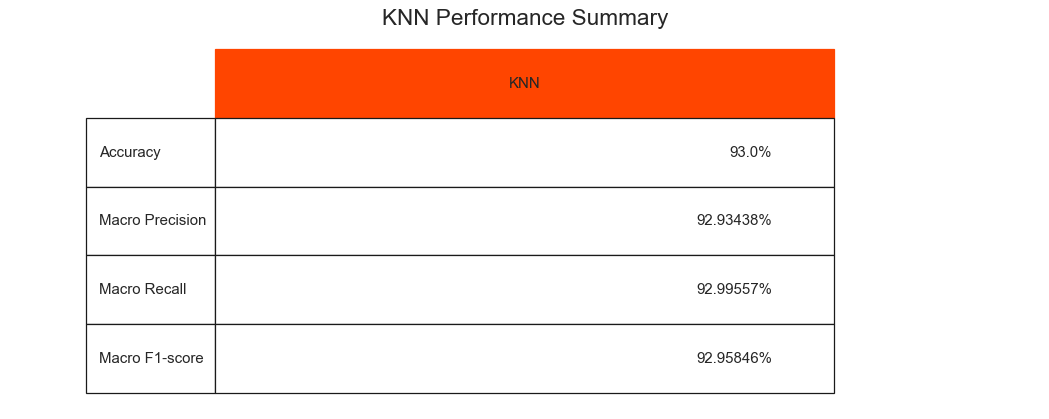



	  NaiveBayes EVALUATION REPORT

		  Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       358
           1       0.80      0.81      0.80       356
           2       0.76      0.76      0.76       345
           3       0.90      0.90      0.90       341

    accuracy                           0.85      1400
   macro avg       0.85      0.85      0.85      1400
weighted avg       0.85      0.85      0.85      1400


		  Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       142
           1       0.77      0.74      0.76       144
           2       0.76      0.81      0.78       155
           3       0.95      0.88      0.91       159

    accuracy                           0.84       600
   macro avg       0.84      0.

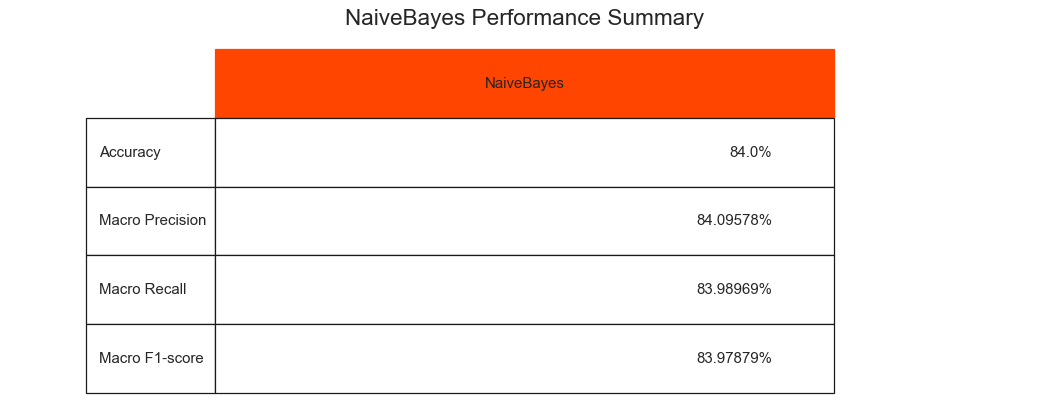



	  KNeighborsClassifier EVALUATION REPORT

		  Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       358
           1       0.95      0.96      0.96       356
           2       0.94      0.94      0.94       345
           3       0.98      0.95      0.96       341

    accuracy                           0.96      1400
   macro avg       0.96      0.96      0.96      1400
weighted avg       0.96      0.96      0.96      1400


		  Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       142
           1       0.90      0.90      0.90       144
           2       0.92      0.90      0.91       155
           3       0.97      0.96      0.96       159

    accuracy                           0.93       600
   macro avg       0.

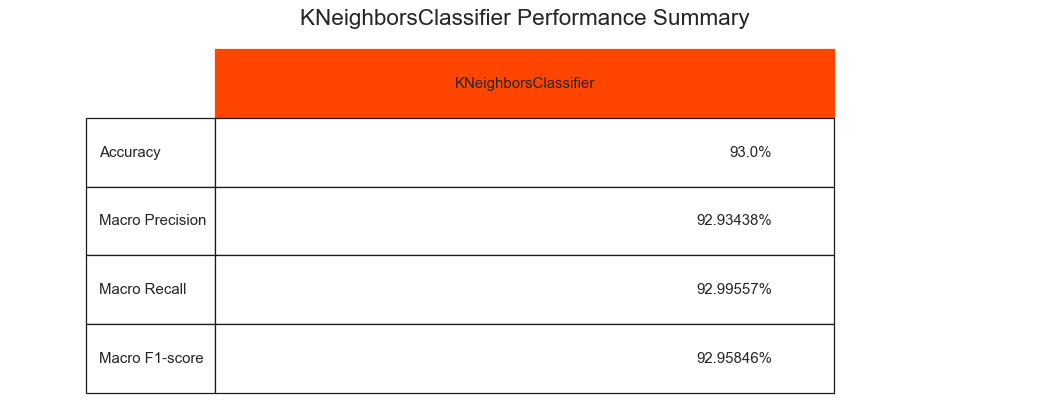



	  GaussianNB EVALUATION REPORT

		  Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       358
           1       0.80      0.81      0.80       356
           2       0.76      0.76      0.76       345
           3       0.90      0.90      0.90       341

    accuracy                           0.85      1400
   macro avg       0.85      0.85      0.85      1400
weighted avg       0.85      0.85      0.85      1400


		  Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       142
           1       0.77      0.74      0.76       144
           2       0.76      0.81      0.78       155
           3       0.95      0.88      0.91       159

    accuracy                           0.84       600
   macro avg       0.84      0.

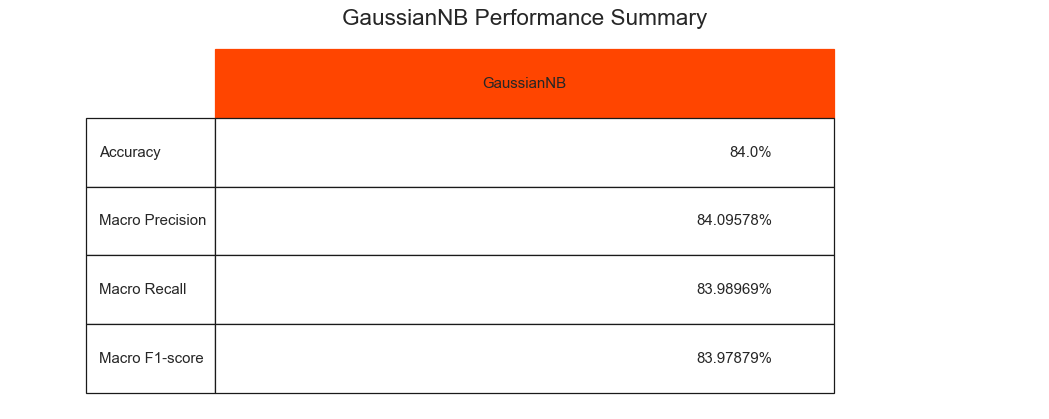

In [29]:
for clf in clfs:
    model_evaluation(clf, X_train, X_val, y_train, y_val)

# Submission

In [30]:
train = pd.read_csv("../data/data_initial_train.csv")
test = pd.read_csv("../data/test.csv")

In [31]:
train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1547,1,2.9,0,2,0,57,0.4,114,1,...,347,957,1620,9,2,19,0,1,1,1
1996,1882,0,2.0,0,11,1,44,0.8,113,8,...,4,743,3579,19,8,20,1,1,0,3
1997,674,1,2.9,1,1,0,21,0.2,198,3,...,576,1809,1180,6,3,4,1,1,1,0
1998,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2


In [32]:
test

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,0,1076,1,2.2,0,3,1,53,0.1,114,...,6,127,1314,1003,16,9,10,1,0,0
1,1,1310,0,2.4,0,0,0,40,0.5,118,...,0,1499,1687,3348,9,2,13,0,0,1
2,2,1915,0,1.1,0,6,0,30,0.6,181,...,8,266,1754,3815,13,4,7,0,0,0
3,3,587,0,1.4,0,9,1,8,0.5,142,...,13,128,593,3182,9,7,10,1,0,0
4,4,1526,0,1.8,0,5,1,11,0.1,131,...,7,150,1606,706,18,7,18,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,1841,0,0.9,0,0,1,13,0.6,112,...,3,1311,1679,1645,15,9,12,1,1,1
1996,1996,1064,1,1.8,1,0,0,12,0.3,147,...,5,105,717,1509,16,10,14,0,0,0
1997,1997,1448,0,1.4,1,0,0,22,0.2,142,...,5,345,652,3807,11,7,9,0,0,0
1998,1998,1085,0,2.4,0,3,1,38,0.7,116,...,8,121,905,885,18,4,8,1,0,0


## Drop ID

ID provide no additional information other than being an identifier, therefore the column is dropped.

In [33]:
# Save id
test_id = test["id"]

# Drop columns
test.drop(columns=["id"], inplace=True)

## Prepare Full Training and Test Data

In [34]:
pipeline = Pipeline([("featureimputer", FeatureImputer()),
                     ("featurecreator", FeatureCreator()),
                     ("dropper", FeatureDropper()),
                     ("pca", CustomPCA(n_components=7))])

In [35]:
train = pipeline.fit_transform(train, train[TARGET])
test = pipeline.transform(test)

Feature screen_size created with 0.041248138514341406 correlation to target
Feature battery_ram_sum created with 0.9255275167140212 correlation to target
Feature ram_mobile_wt created with 0.9174689854467912 correlation to target




In [36]:
test = match_columns(train, test)
test.drop(columns={TARGET}, inplace=True)

In [37]:
train

,price_range,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1,449.990058,-321.955395,-471.520709,-369.329217,-25.323452,58.586963,7.462167
1,2,-836.210387,-614.298073,-228.444558,217.725707,-77.453493,1.309228,-20.891004
2,2,-939.587885,-747.597699,322.935198,-254.912424,198.057034,37.197641,0.864805
3,0,1409.417393,105.579516,-50.727763,116.355397,-80.458552,-65.269987,30.187116
4,0,2667.182924,-529.168404,-442.420826,-219.538383,140.166951,-4.284134,25.934059
...,...,...,...,...,...,...,...,...
1995,1,445.656278,-361.579781,456.675375,3.723750,-55.754753,33.066586,25.135312
1996,3,-2586.659517,-718.335234,684.750370,77.367710,78.704833,30.514535,10.268532
1997,0,1820.608646,249.695331,-581.099668,445.532946,-64.988591,-66.167619,-8.460590
1998,2,-417.477830,802.041004,767.969425,351.392982,28.279930,-52.211992,8.436390


In [38]:
test

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1690.314434,-347.076657,-44.088336,406.173563,70.638332,29.984858,21.182006
1,-1793.489236,908.603625,-178.283886,-280.435229,-73.099287,26.246358,6.952665
2,-2898.877601,164.114775,593.879185,629.928230,-28.450367,-46.188021,-1.069676
3,-972.480701,-937.202848,-748.486332,-146.447000,-16.850786,-4.921632,-24.808156
4,1761.301241,-54.646020,480.909999,616.387118,53.864767,11.426700,-19.892681
...,...,...,...,...,...,...,...
1995,178.745741,872.118126,631.054270,-129.802652,52.516291,33.349902,-19.646300
1996,1008.784375,-773.684602,-28.117412,-15.231020,86.507004,-9.648716,-19.887526
1997,-2540.194473,-606.466026,154.615106,-235.803742,-2.218121,-3.160724,-11.027858
1998,1851.107698,-627.179178,26.878004,115.386455,0.126114,28.827924,6.328562


## Predict Test Set

In [39]:
# Split predictor and target variable
X_train = train.drop([TARGET], axis=1)
y_train = train[TARGET]

X_test = test

In [40]:
final_model = KNN(k=1, n_jobs=-1)
final_model.fit(X_train, y_train)

In [41]:
y_pred_final = final_model.predict(X_test)

Using 16 cores for predictions.


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:01<00:00, 1134.47it/s]


Prediction completed in 2.54 seconds.


In [42]:
y_pred_final

array([0, 3, 3, ..., 3, 0, 3], dtype=int64)

In [43]:
df_submission = pd.DataFrame(data={'id': test_id, 'price_range': y_pred_final})
df_submission

,id,price_range
0,0,0
1,1,3
2,2,3
3,3,2
4,4,0
...,...,...
1995,1995,2
1996,1996,0
1997,1997,3
1998,1998,0


In [44]:
df_submission[TARGET].value_counts()

price_range
2    501
0    500
1    500
3    499
Name: count, dtype: int64

In [45]:
df_submission.iloc[889][TARGET] = 2
df_submission.iloc[1170][TARGET] = 3
df_submission.iloc[1568][TARGET] = 3

In [46]:
df_submission[TARGET].value_counts()

price_range
0    500
3    500
2    500
1    500
Name: count, dtype: int64

In [47]:
df_submission.to_csv("../data/knn-submission.csv", index=False)